Relevant Packages: pandas, numpy, matplotlib, statsmodels, pandas_datareader, yfinance, sklearn, PyPortfolioOpt

## Import Data + Packages

In [1]:
# Packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import warnings
import datetime as dt
import pandas_ta
import zipfile
warnings.filterwarnings('ignore')

C:\Users\ynakadi\Anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
# S&P 500 Stocks
sp500_df = pd.read_csv('sp500_companies.csv')
sp500_df.head(5)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,404.06,3002343620608,1.184270e+11,0.176,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.064672
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,182.31,2815212650496,1.301090e+11,0.021,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.060641
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,726.13,1793541144576,2.216100e+10,2.055,Santa Clara,CA,United States,26196.0,"NVIDIA Corporation provides graphics, and comp...",0.038634
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,169.51,1760768032768,8.551500e+10,0.139,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.037928
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,140.52,1754293862400,1.001720e+11,0.135,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.037788


## Create Dataframe

In [3]:
symbols_list = sp500_df['Symbol'].unique().tolist()

In [16]:
start_date = "2016-01-01"
end_date = "2024-03-01"
stocks_df = pd.DataFrame()
random.shuffle(symbols_list)
for stock in symbols_list:
    df = yf.download(stock, start = start_date, end = end_date)
    df['company'] = stock
    stocks_df = pd.concat([stocks_df,df])
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [17]:
stocks_df

,Open,High,Low,Close,Adj Close,Volume,company
Date,,,,,,,
2016-01-04,41.349998,41.939999,41.040001,41.919998,39.499378,654100,J
2016-01-05,41.750000,42.119999,41.040001,41.330002,38.943451,632000,J
2016-01-06,40.480000,40.900002,40.299999,40.529999,38.189648,861600,J
2016-01-07,39.889999,40.299999,39.270000,39.439999,37.162594,1074200,J
2016-01-08,39.599998,39.950001,38.590000,38.750000,36.512428,1070300,J
...,...,...,...,...,...,...,...
2024-02-12,15.330000,15.640000,15.280000,15.490000,15.490000,28026400,CCL
2024-02-13,15.030000,15.240000,14.900000,15.120000,15.120000,26733700,CCL
2024-02-14,15.260000,15.360000,14.840000,15.270000,15.270000,25927100,CCL


In [4]:
start_date = "2016-01-01"
end_date = "2024-03-01"
stocks_df = yf.download(symbols_list, start = start_date, end = end_date)

[*********************100%%**********************]  502 of 502 completed


In [5]:
stocks_df = stocks_df.stack()

## Create Features

Features:
* **Garman-Klass Volatility** 
* **RSI** 
* **Bollinger Bands** 
* **ATR** 
* **MACD** 
* **Dollar Volume**

G-K Volatility = (ln(High) - ln(Low))**2 / 2 - (2*ln(2) - 1)(ln(Adj Close) - ln(Open))**2

In [6]:
stocks_df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2016-01-04 A        38.134426   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.946922   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778629   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2024-02-20 YUM     133.949997  133.949997  134.660004  133.089996  133.789993   
           ZBH     124.980003  124.980003  125.940002  122.580002  124.940002   
           ZBRA    271.929993  271.929993  272.390015  267.380005  269.859985   
           ZION     40.090000   40.090000   40.650002   39.840000   39.919998   
           ZTS     186.550003  186.550003  189.410004  186.240005  187.300003   

Price                   Volume  
Date       Ticker               
2016-01-04 A         3287300.0  
           AAL      12037200.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
...                        ...  
2024-02-20 YUM       2199108.0  
           ZBH       1304349.0  
           ZBRA       523766.0  
           ZION      1839419.0  
           ZTS       2501009.0  

[1010146 rows x 6 columns]

In [7]:
stocks_df['GK Volatility'] = ((np.log(stocks_df['High']) - np.log(stocks_df['Low']))**2 / 2) - \
                             ((2 * np.log(2) - 1) * (np.log(stocks_df['Adj Close']) - np.log(stocks_df['Open']))**2)

In [8]:
stocks_df['RSI'] = stocks_df.groupby(by='Ticker')['Adj Close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))

In [9]:
stocks_df['BB_Low'] = stocks_df.groupby(by='Ticker')['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)
                                                                                                        ,length=20).iloc[:,0])
stocks_df['BB_Mid'] = stocks_df.groupby(by='Ticker')['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)
                                                                                                        ,length=20).iloc[:,1])
stocks_df['BB_Upper'] = stocks_df.groupby(by='Ticker')['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)
                                                                                                        ,length=20).iloc[:,2])

In [10]:
def compute_atr(data):
    atr = pandas_ta.atr(high=data['High'], low = data['Low'], close = data['Close'], length = 14)
    # normalize
    return atr.sub(atr.mean()).div(atr.std())
    
stocks_df['ATR'] = stocks_df.groupby(by='Ticker',group_keys=False).apply(compute_atr)

In [11]:
def compute_macd(data):
    macd = pandas_ta.macd(close = data['Close'], length = 20).iloc[:,0]
    # normalize
    return macd.sub(macd.mean()).div(macd.std())
    
stocks_df['MACD'] = stocks_df.groupby(by='Ticker',group_keys=False).apply(compute_macd)

In [12]:
stocks_df['dollar_volume'] = (stocks_df['Adj Close'] * stocks_df['Volume']) / 1e6

In [13]:
stocks_df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2016-01-04 A        38.134426   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.946922   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778629   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2024-02-20 YUM     133.949997  133.949997  134.660004  133.089996  133.789993   
           ZBH     124.980003  124.980003  125.940002  122.580002  124.940002   
           ZBRA    271.929993  271.929993  272.390015  267.380005  269.859985   
           ZION     40.090000   40.090000   40.650002   39.840000   39.919998   
           ZTS     186.550003  186.550003  189.410004  186.240005  187.300003   

Price                   Volume  GK Volatility        RSI    BB_Low    BB_Mid  \
Date       Ticker                                                              
2016-01-04 A         3287300.0      -0.001893        NaN       NaN       NaN   
           AAL      12037200.0      -0.000821        NaN       NaN       NaN   
           AAPL    270597600.0      -0.001300        NaN       NaN       NaN   
           ABBV     10308400.0      -0.050297        NaN       NaN       NaN   
           ABT      12227500.0      -0.011585        NaN       NaN       NaN   
...                        ...            ...        ...       ...       ...   
2024-02-20 YUM       2199108.0       0.000068  59.275578  4.846433  4.880665   
           ZBH       1304349.0       0.000366  55.352177  4.794191  4.828566   
           ZBRA       523766.0       0.000150  58.055654  5.452844  5.539538   
           ZION      1839419.0       0.000196  48.512403  3.640540  3.734965   
           ZTS       2501009.0       0.000136  46.224830  5.210517  5.254259   

Price              BB_Upper       ATR      MACD  dollar_volume  
Date       Ticker                                               
2016-01-04 A            NaN       NaN       NaN     125.359299  
           AAL          NaN       NaN       NaN     470.599859  
           AAPL         NaN       NaN       NaN    6479.979702  
           ABBV         NaN       NaN       NaN     416.378487  
           ABT          NaN       NaN       NaN     449.710690  
...                     ...       ...       ...            ...  
2024-02-20 YUM     4.914897  0.366502  0.643326     294.570510  
           ZBH     4.862941 -0.008002  0.280574     163.017542  
           ZBRA    5.626232  0.678319  0.520674     142.427685  
           ZION    3.829391  0.369894 -0.441131      73.742308  
           ZTS     5.298001  1.077486 -0.597017     466.563237  

[1010146 rows x 14 columns]

## Aggregation, Find most Liquid Stocks

In [14]:
# Aggregate to Monthly Level

feature_cols = [x for x in stocks_df.columns if x not in ['Close','High','Low','Volume','Open','Close','dollar_volume']]
stocks_df.unstack()['dollar_volume'].resample('M').mean().stack().to_frame('Dollar Volume')

Dollar Volume
Date       Ticker               
2016-01-31 A           95.208701
           AAL        475.457991
           AAPL      5973.584302
           ABBV       455.892222
           ABT        324.439096
...                          ...
2024-02-29 YUM        310.034765
           ZBH        234.702965
           ZBRA       137.495501
           ZION       141.273660
           ZTS        433.948146

[48393 rows x 1 columns]

In [112]:
stock_feature_df = pd.concat([stocks_df.unstack()[feature_cols].resample('M').last().stack(),
           stocks_df.unstack()['dollar_volume'].resample('M').mean().stack().to_frame('Dollar Volume')], axis=1)

In [113]:
stock_feature_df['Dollar Volume'] = stock_feature_df.loc[:,'Dollar Volume'].unstack().rolling(12*5,min_periods=12).mean().stack()

In [114]:
stock_feature_df["Dol_Vol_Rank"] = stock_feature_df.groupby('Date')['Dollar Volume'].rank(ascending=False)

In [115]:
stock_feature_df = stock_feature_df[stock_feature_df['Dol_Vol_Rank'] <= 150].drop(['Dol_Vol_Rank','Dollar Volume'],axis=1)

### Calculate Monthly Lags and Returns

In [116]:
def calculate_returns(data):
    # Monthly Lags
    lags = [1, 2, 3, 6, 9, 12]

    outlier_cutoff = 0.05

    for lag in lags:
        data[f'returns_{lag}m'] = (data['Adj Close'].pct_change(lag)\
                                .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),upper = x.quantile(1-outlier_cutoff)))\
                                .add(1).pow(1/lag).sub(1))
    return data

In [117]:
stock_feature_df = stock_feature_df.groupby(by='Ticker',group_keys=False).apply(calculate_returns).dropna()
stock_feature_df

ATR   Adj Close    BB_Low    BB_Mid  BB_Upper  \
Date       Ticker                                                       
2017-12-31 AAL    -0.053411   50.711880  3.884601  3.928729  3.972856   
           AAPL   -1.021443   39.955589  3.702204  3.727634  3.753063   
           ABBV   -0.718209   72.997505  4.279765  4.304562  4.329358   
           ABT    -1.146950   51.286049  3.899620  3.936665  3.973710   
           ACN    -0.940480  139.691666  4.903882  4.933999  4.964117   
...                     ...         ...       ...       ...       ...   
2024-02-29 VRTX    1.281351  420.640015  6.021085  6.058118  6.095151   
           VZ     -0.210229   40.500000  3.695920  3.742364  3.788808   
           WFC     0.339565   51.770000  3.872552  3.920950  3.969349   
           WMT     0.730140  175.860001  5.087550  5.127983  5.168416   
           XOM     0.433059  102.750000  4.598814  4.630226  4.661638   

                   GK Volatility      MACD        RSI  returns_1m  returns_2m  \
Date       Ticker                                                               
2017-12-31 AAL         -0.000305  1.246577  59.214261    0.030501    0.055325   
           AAPL        -0.001589 -0.232479  47.784594   -0.015246    0.002359   
           ABBV        -0.033683  0.261513  55.000861   -0.002167    0.035171   
           ABT         -0.005133  0.246392  59.877734    0.012418    0.025851   
           ACN         -0.003838  0.283566  65.003665    0.034322    0.037001   
...                          ...       ...        ...         ...         ...   
2024-02-29 VRTX         0.000220 -0.127015  51.814781   -0.029397    0.016756   
           VZ           0.000122  0.321033  54.957966   -0.043684    0.045173   
           WFC          0.000165  0.664017  63.759560    0.038932    0.029172   
           WMT          0.000505  1.677273  73.283321    0.064206    0.056177   
           XOM          0.000059  0.332458  54.189369    0.008705    0.018458   

                   returns_3m  returns_6m  returns_9m  returns_12m  
Date       Ticker                                                   
2017-12-31 AAL       0.031654    0.006292    0.023994     0.009787  
           AAPL      0.032901    0.028535    0.019684     0.033479  
           ABBV      0.031007    0.051953    0.047360     0.037472  
           ABT       0.024323    0.028884    0.030147     0.032291  
           ACN       0.045983    0.037860    0.029824     0.024265  
...                       ...         ...         ...          ...  
2024-02-29 VRTX      0.058372    0.031932    0.029580     0.031391  
           VZ        0.024219    0.028437    0.020621     0.009598  
           WFC       0.053481    0.041169    0.032329     0.011147  
           WMT       0.042731    0.013767    0.021040     0.019189  
           XOM       0.003121   -0.010047    0.003571    -0.002680  

[10866 rows x 14 columns]

### FAMA-French Factors

In [109]:
factor_df = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF',axis=1)
factor_df.index = factor_df.index.to_timestamp()

In [110]:
factor_df = factor_df.resample('M').last().div(100)
factor_df

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-08-31,-0.0239,-0.0365,-0.0106,0.0343,-0.0237
2023-09-30,-0.0524,-0.0180,0.0152,0.0186,-0.0083
2023-10-31,-0.0319,-0.0404,0.0019,0.0246,-0.0066


In [104]:
# Merge with Stock Features to Evaluate 1 month returns
factor_df = factor_df.join(stock_feature_df['returns_1m'])

In [108]:
# Filter stocks with < 12 months of data
min_months = 12
observations = factor_df.groupby('Ticker').size()
valid_stocks = observations[observations >= min_months]
factor_df = factor_df[factor_df.index.get_level_values('Ticker').isin(valid_stocks.index)]
factor_df

Mkt-RF     SMB     HML     RMW     CMA  returns_1m
Date       Ticker                                                    
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169    0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169   -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169   -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169    0.012418
           ACN     0.0106 -0.0107  0.0006  0.0074  0.0169    0.034322
...                   ...     ...     ...     ...     ...         ...
2023-12-31 VRTX    0.0485  0.0732  0.0494 -0.0307  0.0132    0.146382
           VZ      0.0485  0.0732  0.0494 -0.0307  0.0132   -0.016436
           WFC     0.0485  0.0732  0.0494 -0.0307  0.0132    0.103835
           WMT     0.0485  0.0732  0.0494 -0.0307  0.0132    0.016350
           XOM     0.0485  0.0732  0.0494 -0.0307  0.0132   -0.026864

[10511 rows x 6 columns]

### Calculate Rolling Factor Betas

In [25]:
betas = factor_df.groupby(level=1,group_keys=False).apply(lambda x: RollingOLS(endog = x['returns_1m'],
                                                                          exog = sm.add_constant(x.drop('returns_1m',axis=1)),
                                                                          window = min(24,x.shape[0]), # 2 years
                                                                          min_nobs = len(x.columns) + 1)\
                                                                          .fit(params_only=True).params.drop('const',axis=1))

In [26]:
# Combine everything
stock_features_df = betas.groupby(by='Ticker').shift().join(stock_feature_df)

In [27]:
factors = ['Mkt-RF', "SMB", "HML", "RMW", "CMA"]
stock_features_df.loc[:, factors] = stock_features_df.groupby('Ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))


stock_features_df = stock_features_df.dropna()
stock_features_df = stock_features_df.drop('Adj Close',axis=1)

In [101]:
stock_features_df#.info()

Mkt-RF       SMB       HML       RMW       CMA       ATR  \
Date       Ticker                                                               
2017-12-31 AAL     0.988199  1.416356  0.330898  0.502107  0.613377 -0.053411   
           AAPL    1.273569 -0.341822 -0.557521  0.380638  0.581251 -1.021443   
           ABBV    0.387795  0.405398 -0.055757  0.416496  0.216017 -0.718209   
           ABT     0.751890 -0.241492 -0.418848  0.173857  0.796476 -1.146950   
           ACN     1.119493 -0.267223 -0.217404  0.225170  0.022736 -0.940480   
...                     ...       ...       ...       ...       ...       ...   
2023-12-31 VRTX    0.362007 -0.337949 -0.424691  0.278338  0.825115  1.064869   
           VZ      0.425671 -0.601982  0.432179  0.151487 -0.119633 -1.187532   
           WFC     1.055134  0.159445  1.824730 -0.399864 -1.368129 -0.753272   
           WMT     0.491889  0.061532 -0.473873  0.613397  0.558824 -0.005063   
           XOM     0.652394 -0.134616  0.981915  0.229076  0.152851  0.068332   

                     BB_Low    BB_Mid  BB_Upper  GK Volatility      MACD  \
Date       Ticker                                                          
2017-12-31 AAL     3.884601  3.928729  3.972856      -0.000305  1.246577   
           AAPL    3.702204  3.727634  3.753063      -0.001589 -0.232479   
           ABBV    4.279765  4.304562  4.329358      -0.033683  0.261513   
           ABT     3.899620  3.936665  3.973710      -0.005133  0.246392   
           ACN     4.903882  4.933999  4.964117      -0.003838  0.283566   
...                     ...       ...       ...            ...       ...   
2023-12-31 VRTX    5.817492  5.953002  6.088512       0.000028  3.025776   
           VZ      3.616386  3.640871  3.665356       0.000043  0.427882   
           WFC     3.793252  3.881014  3.968775      -0.000008  1.754704   
           WMT     5.018094  5.045321  5.072549       0.000017 -0.342994   
           XOM     4.584927  4.613518  4.642108      -0.000020 -0.594809   

                         RSI  returns_1m  returns_2m  returns_3m  returns_6m  \
Date       Ticker                                                              
2017-12-31 AAL     59.214261    0.030501    0.055325    0.031654    0.006292   
           AAPL    47.784594   -0.015246    0.002359    0.032901    0.028535   
           ABBV    55.000861   -0.002167    0.035171    0.031007    0.051953   
           ABT     59.877734    0.012418    0.025851    0.024323    0.028884   
           ACN     65.003665    0.034322    0.037001    0.045983    0.037860   
...                      ...         ...         ...         ...         ...   
2023-12-31 VRTX    65.899356    0.146382    0.060030    0.053758    0.024490   
           VZ      57.985178   -0.016436    0.035933    0.041211    0.008786   
           WFC     67.347851    0.103835    0.096261    0.067168    0.026895   
           WMT     52.372668    0.016350   -0.015960   -0.003544    0.001708   
           XOM     42.607130   -0.026864   -0.023690   -0.049736   -0.008782   

                   returns_9m  returns_12m  cluster  
Date       Ticker                                    
2017-12-31 AAL       0.023994     0.009787        2  
           AAPL      0.019684     0.033479        1  
           ABBV      0.047360     0.037472        2  
           ABT       0.030147     0.032291        2  
           ACN       0.029824     0.024265        3  
...                       ...          ...      ...  
2023-12-31 VRTX      0.028824     0.028985        0  
           VZ        0.002693     0.002233        2  
           WFC       0.033852     0.017357        0  
           WMT       0.008697     0.010148        1  
           XOM      -0.007363    -0.005374        1  

[10372 rows x 19 columns]

## ML Models

### KMeans Clustering

In [29]:
# Notes: 
# Optimal # of clusters is around 4
# Initialize predefined centroids for each cluster based on your research

In [36]:
from sklearn.cluster import KMeans
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, random_state = 42, init = 'random').fit(df).labels_
    return df

stock_features_df = stock_features_df.groupby('Date',group_keys=False).apply(get_clusters)
stock_features_df

Mkt-RF       SMB       HML       RMW       CMA       ATR  \
Date       Ticker                                                               
2017-12-31 AAL     0.988199  1.416356  0.330898  0.502107  0.613377 -0.053411   
           AAPL    1.273569 -0.341822 -0.557521  0.380638  0.581251 -1.021443   
           ABBV    0.387795  0.405398 -0.055757  0.416496  0.216017 -0.718209   
           ABT     0.751890 -0.241492 -0.418848  0.173857  0.796476 -1.146950   
           ACN     1.119493 -0.267223 -0.217404  0.225170  0.022736 -0.940480   
...                     ...       ...       ...       ...       ...       ...   
2023-12-31 VRTX    0.362007 -0.337949 -0.424691  0.278338  0.825115  1.064869   
           VZ      0.425671 -0.601982  0.432179  0.151487 -0.119633 -1.187532   
           WFC     1.055134  0.159445  1.824730 -0.399864 -1.368129 -0.753272   
           WMT     0.491889  0.061532 -0.473873  0.613397  0.558824 -0.005063   
           XOM     0.652394 -0.134616  0.981915  0.229076  0.152851  0.068332   

                     BB_Low    BB_Mid  BB_Upper  GK Volatility      MACD  \
Date       Ticker                                                          
2017-12-31 AAL     3.884601  3.928729  3.972856      -0.000305  1.246577   
           AAPL    3.702204  3.727634  3.753063      -0.001589 -0.232479   
           ABBV    4.279765  4.304562  4.329358      -0.033683  0.261513   
           ABT     3.899620  3.936665  3.973710      -0.005133  0.246392   
           ACN     4.903882  4.933999  4.964117      -0.003838  0.283566   
...                     ...       ...       ...            ...       ...   
2023-12-31 VRTX    5.817492  5.953002  6.088512       0.000028  3.025776   
           VZ      3.616386  3.640871  3.665356       0.000043  0.427882   
           WFC     3.793252  3.881014  3.968775      -0.000008  1.754704   
           WMT     5.018094  5.045321  5.072549       0.000017 -0.342994   
           XOM     4.584927  4.613518  4.642108      -0.000020 -0.594809   

                         RSI  returns_1m  returns_2m  returns_3m  returns_6m  \
Date       Ticker                                                              
2017-12-31 AAL     59.214261    0.030501    0.055325    0.031654    0.006292   
           AAPL    47.784594   -0.015246    0.002359    0.032901    0.028535   
           ABBV    55.000861   -0.002167    0.035171    0.031007    0.051953   
           ABT     59.877734    0.012418    0.025851    0.024323    0.028884   
           ACN     65.003665    0.034322    0.037001    0.045983    0.037860   
...                      ...         ...         ...         ...         ...   
2023-12-31 VRTX    65.899356    0.146382    0.060030    0.053758    0.024490   
           VZ      57.985178   -0.016436    0.035933    0.041211    0.008786   
           WFC     67.347851    0.103835    0.096261    0.067168    0.026895   
           WMT     52.372668    0.016350   -0.015960   -0.003544    0.001708   
           XOM     42.607130   -0.026864   -0.023690   -0.049736   -0.008782   

                   returns_9m  returns_12m  cluster  
Date       Ticker                                    
2017-12-31 AAL       0.023994     0.009787        0  
           AAPL      0.019684     0.033479        3  
           ABBV      0.047360     0.037472        2  
           ABT       0.030147     0.032291        0  
           ACN       0.029824     0.024265        0  
...                       ...          ...      ...  
2023-12-31 VRTX      0.028824     0.028985        0  
           VZ        0.002693     0.002233        1  
           WFC       0.033852     0.017357        0  
           WMT       0.008697     0.010148        2  
           XOM      -0.007363    -0.005374        2  

[10372 rows x 19 columns]

In [81]:
def plot_clusters(df):
    cluster_0 = df[df['cluster'] == 0]
    cluster_1 = df[df['cluster'] == 1]
    cluster_2 = df[df['cluster'] == 2]
    cluster_3 = df[df['cluster'] == 3]
    # 5 is ATR, 11 is RSI
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,11],color='red',label = 'Cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,11],color='black',label = 'Cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,11],color='green',label = 'Cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,11],color='blue',label = 'Cluster 3')

    plt.legend()
    plt.show()
    return

In [82]:
int(np.sqrt(len(stock_features_df.index.get_level_values('Date').unique().tolist())))

8

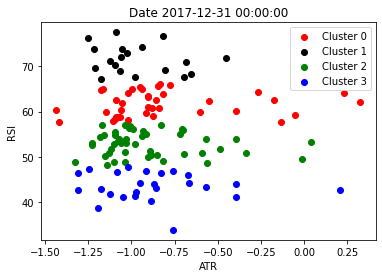

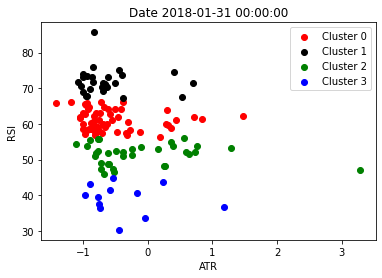

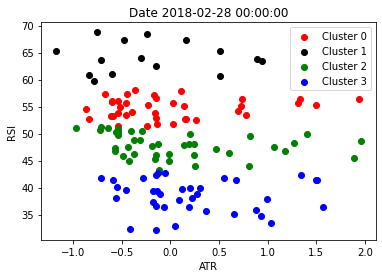

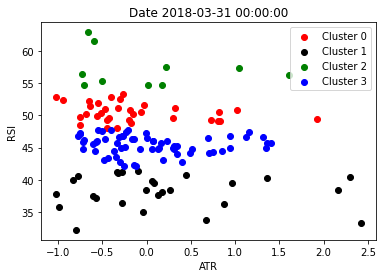

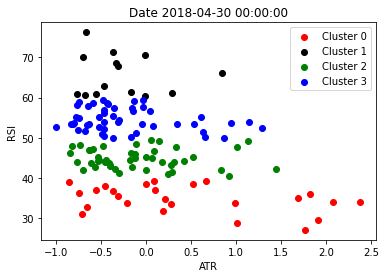

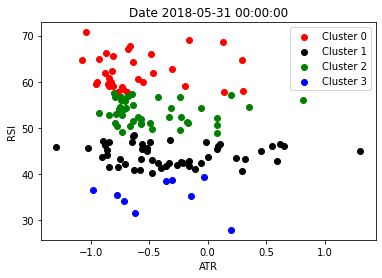

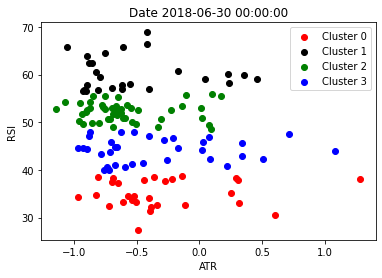

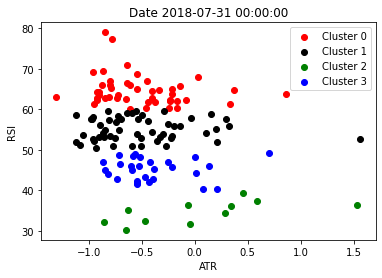

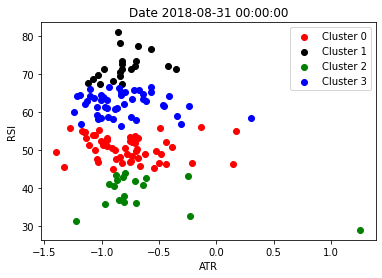

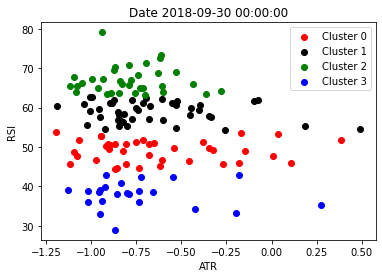

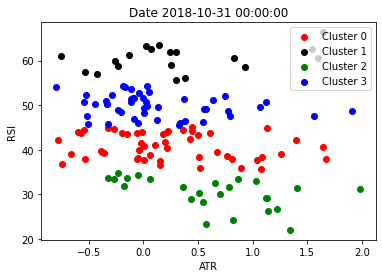

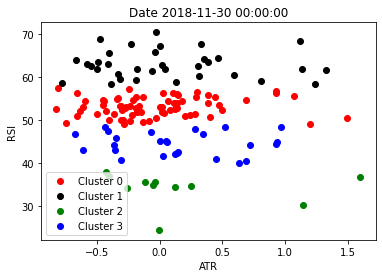

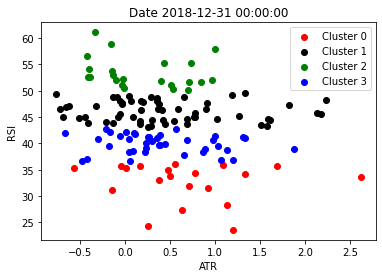

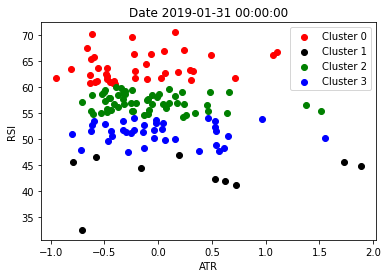

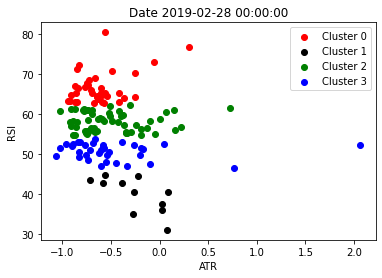

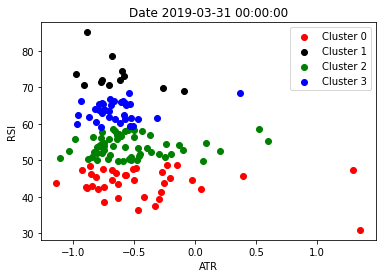

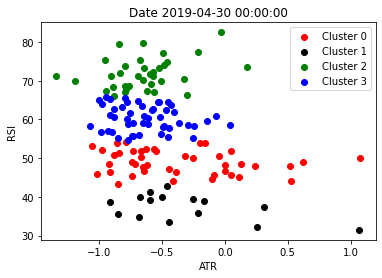

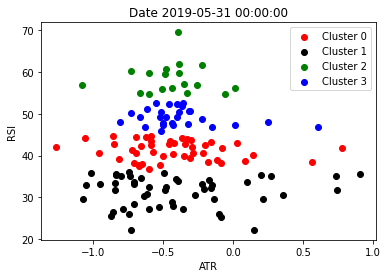

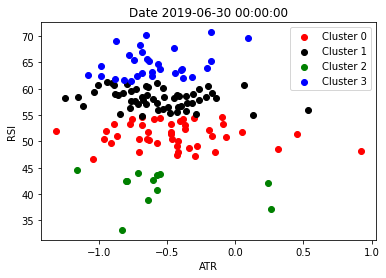

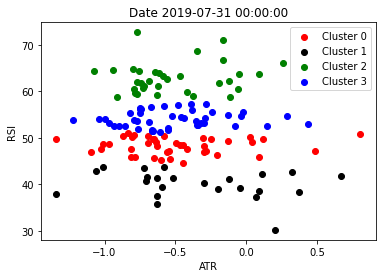

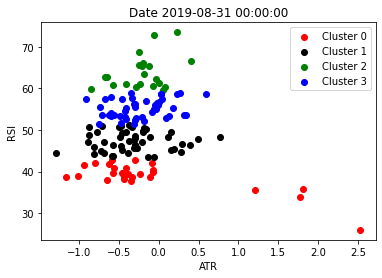

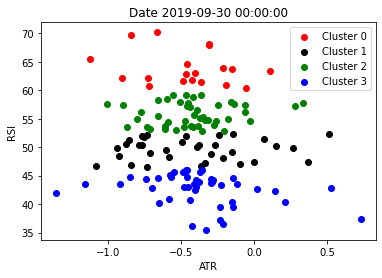

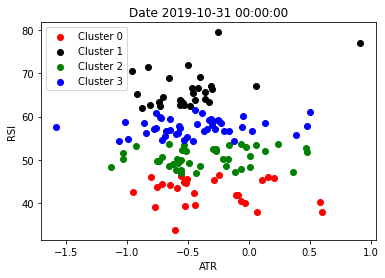

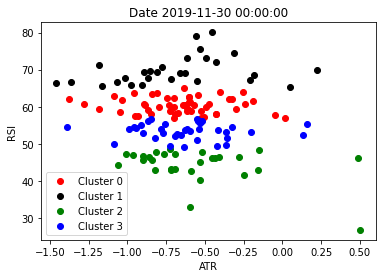

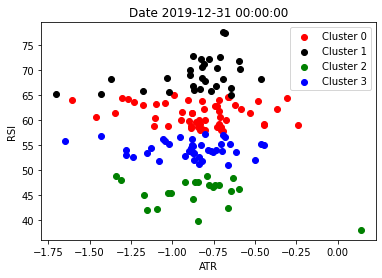

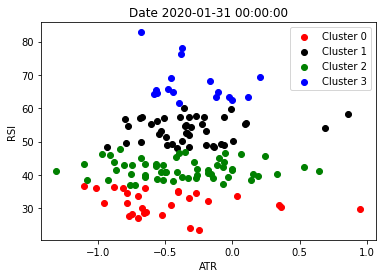

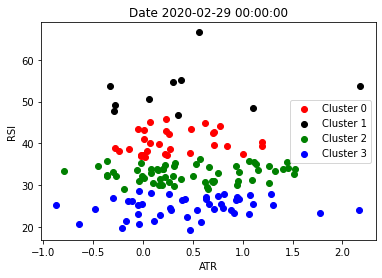

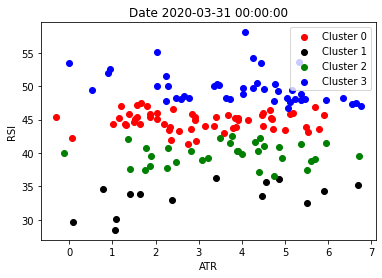

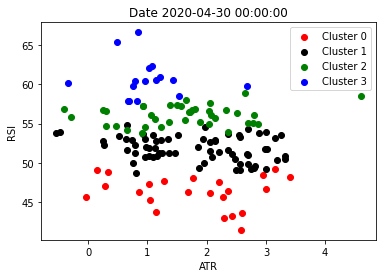

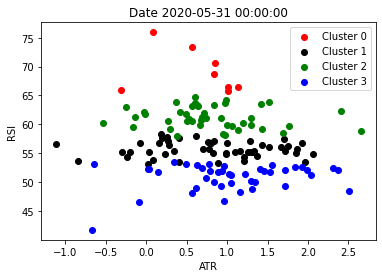

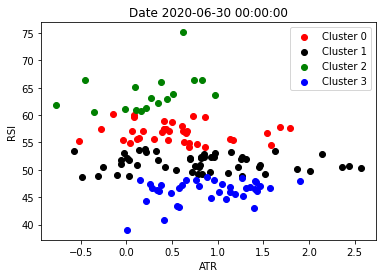

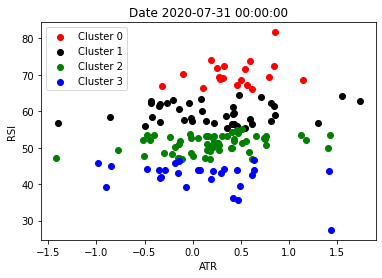

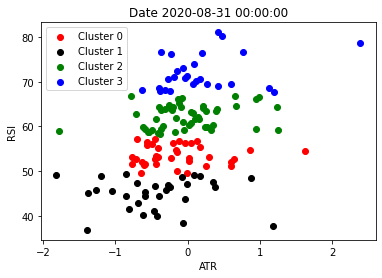

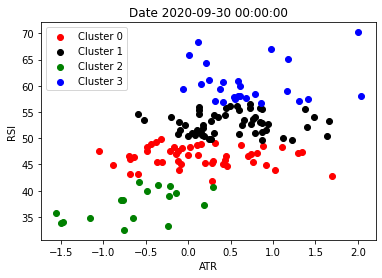

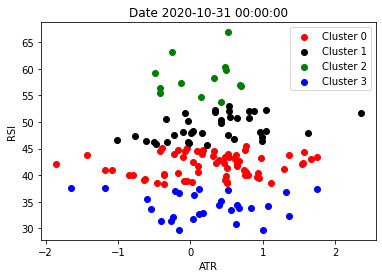

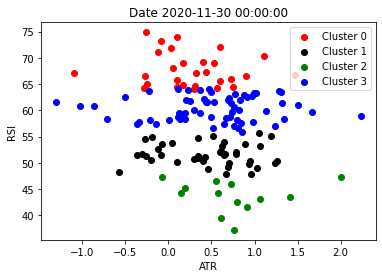

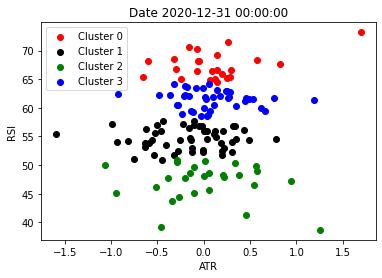

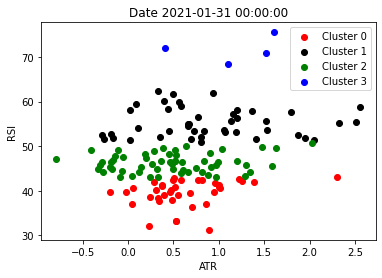

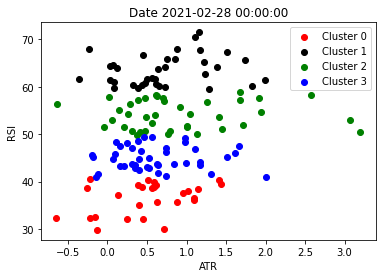

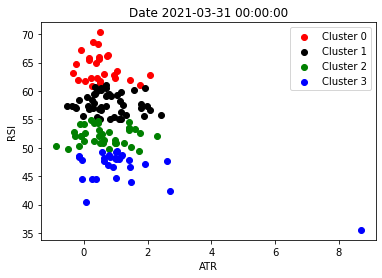

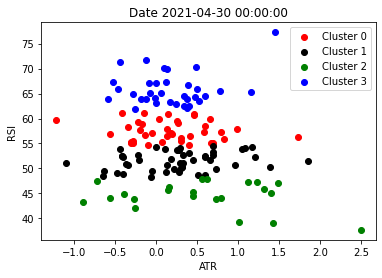

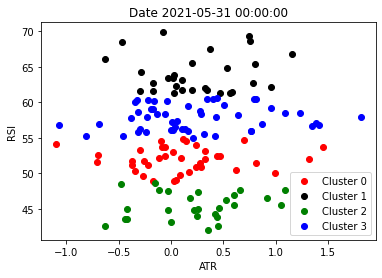

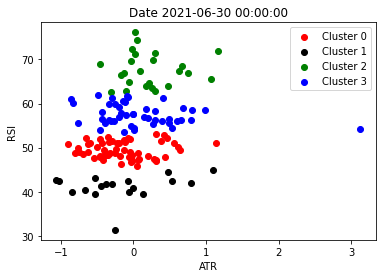

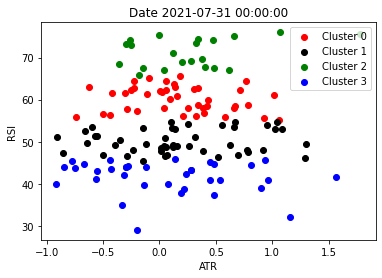

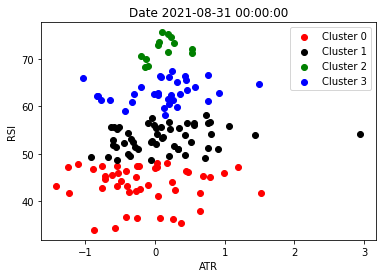

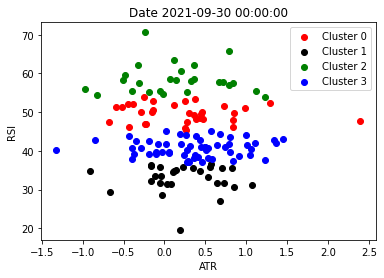

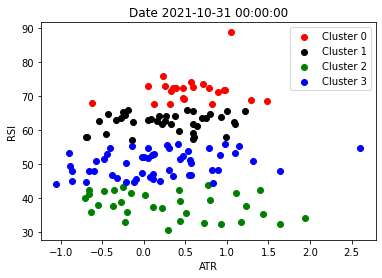

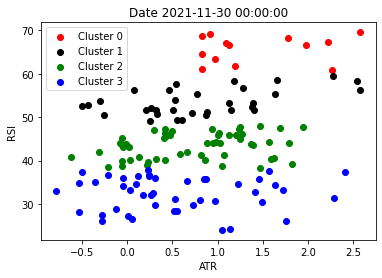

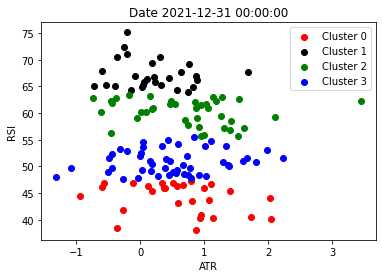

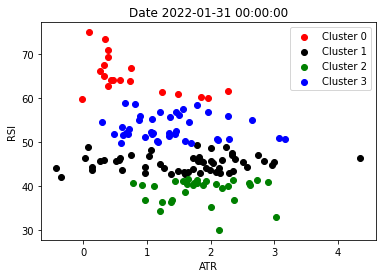

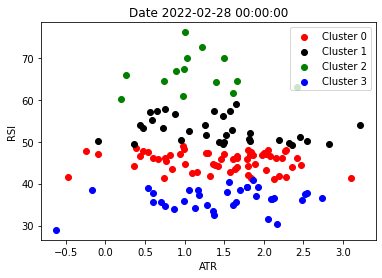

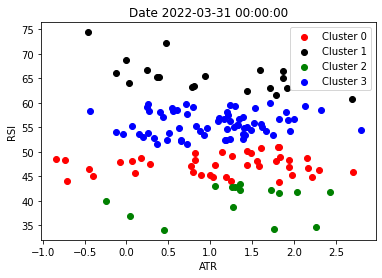

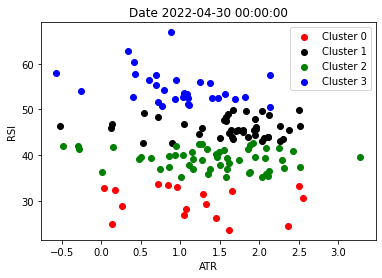

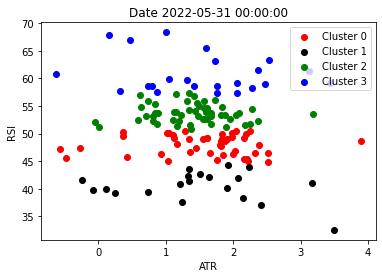

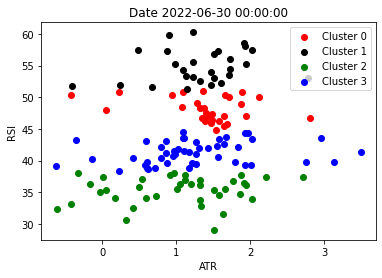

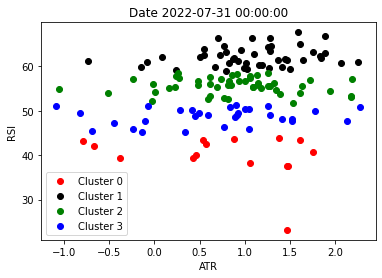

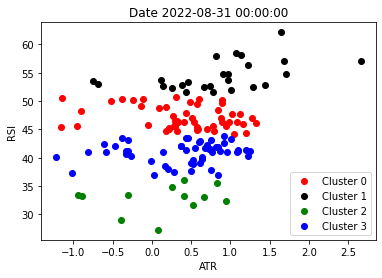

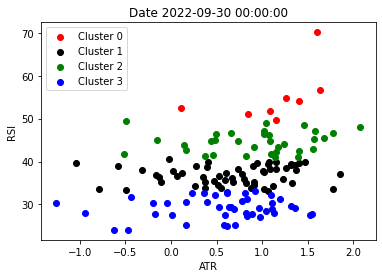

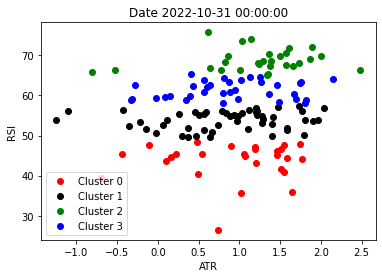

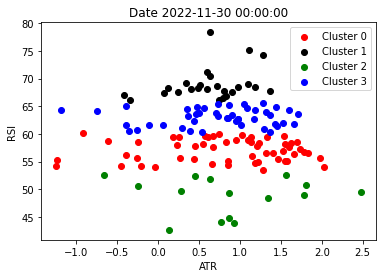

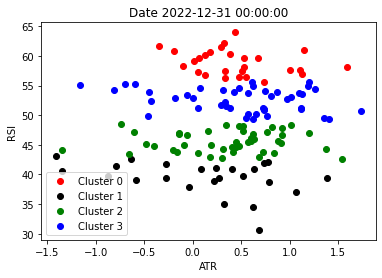

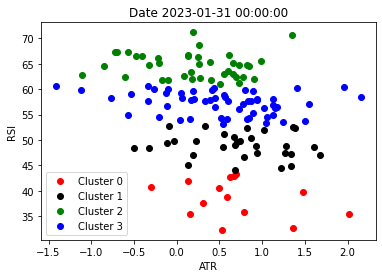

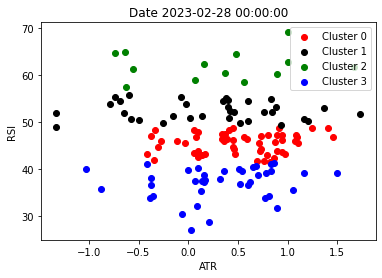

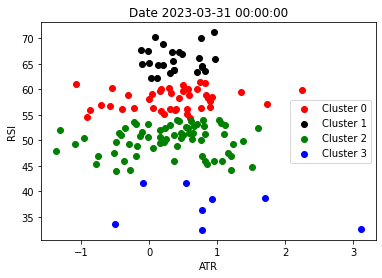

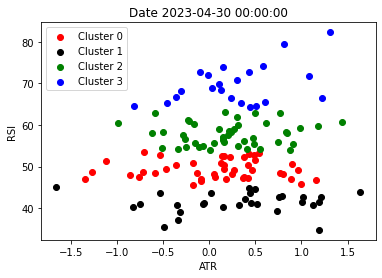

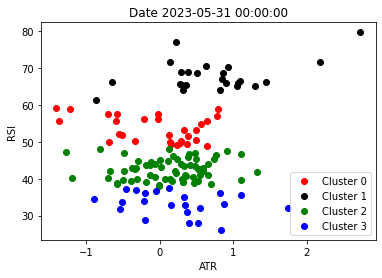

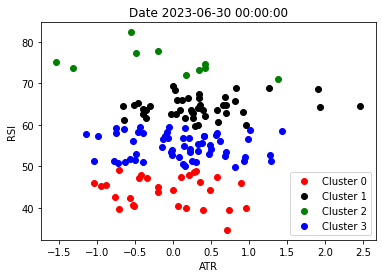

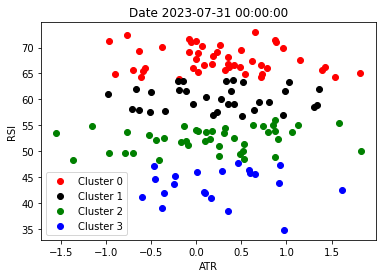

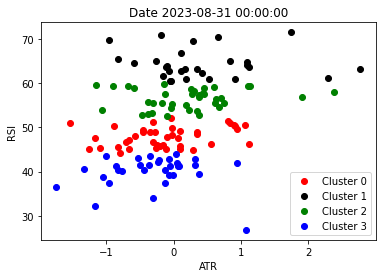

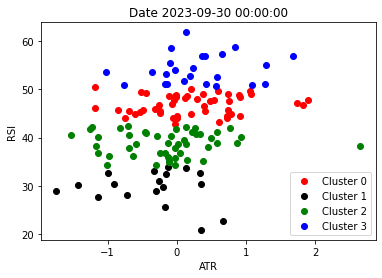

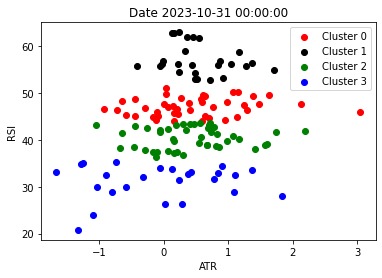

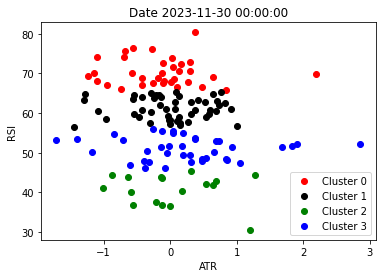

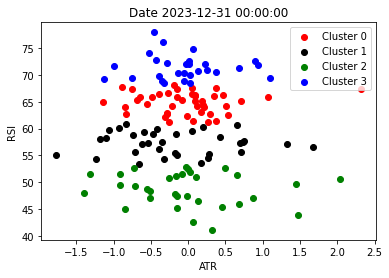

In [83]:
for i in stock_features_df.index.get_level_values('Date').unique().tolist():
    g = stock_features_df.xs(i,level=0)
    plt.title(f'Date {i}')
    plt.xlabel("ATR")
    plt.ylabel("RSI")
    plot_clusters(g)

In [58]:
stock_features_df.columns[11]

'RSI'

### Pre-Defined Centroids

In [86]:
# Must be shape (n_features, n_clusters)
initial_centroids = np.zeros((4,18))

### Target RSI Values

In [87]:
target_rsi_values = [30, 45, 55, 70]
initial_centroids[:, 11] = target_rsi_values
initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [93]:
def get_clusters_improved(df):
    df['cluster'] = KMeans(n_clusters = 4, random_state = 42, init = initial_centroids).fit(df).labels_
    return df
stock_features_df = stock_features_df.drop('cluster',axis=1)
stock_features_df = stock_features_df.groupby('Date',group_keys=False).apply(get_clusters_improved)
stock_features_df

Mkt-RF       SMB       HML       RMW       CMA       ATR  \
Date       Ticker                                                               
2017-12-31 AAL     0.988199  1.416356  0.330898  0.502107  0.613377 -0.053411   
           AAPL    1.273569 -0.341822 -0.557521  0.380638  0.581251 -1.021443   
           ABBV    0.387795  0.405398 -0.055757  0.416496  0.216017 -0.718209   
           ABT     0.751890 -0.241492 -0.418848  0.173857  0.796476 -1.146950   
           ACN     1.119493 -0.267223 -0.217404  0.225170  0.022736 -0.940480   
...                     ...       ...       ...       ...       ...       ...   
2023-12-31 VRTX    0.362007 -0.337949 -0.424691  0.278338  0.825115  1.064869   
           VZ      0.425671 -0.601982  0.432179  0.151487 -0.119633 -1.187532   
           WFC     1.055134  0.159445  1.824730 -0.399864 -1.368129 -0.753272   
           WMT     0.491889  0.061532 -0.473873  0.613397  0.558824 -0.005063   
           XOM     0.652394 -0.134616  0.981915  0.229076  0.152851  0.068332   

                     BB_Low    BB_Mid  BB_Upper  GK Volatility      MACD  \
Date       Ticker                                                          
2017-12-31 AAL     3.884601  3.928729  3.972856      -0.000305  1.246577   
           AAPL    3.702204  3.727634  3.753063      -0.001589 -0.232479   
           ABBV    4.279765  4.304562  4.329358      -0.033683  0.261513   
           ABT     3.899620  3.936665  3.973710      -0.005133  0.246392   
           ACN     4.903882  4.933999  4.964117      -0.003838  0.283566   
...                     ...       ...       ...            ...       ...   
2023-12-31 VRTX    5.817492  5.953002  6.088512       0.000028  3.025776   
           VZ      3.616386  3.640871  3.665356       0.000043  0.427882   
           WFC     3.793252  3.881014  3.968775      -0.000008  1.754704   
           WMT     5.018094  5.045321  5.072549       0.000017 -0.342994   
           XOM     4.584927  4.613518  4.642108      -0.000020 -0.594809   

                         RSI  returns_1m  returns_2m  returns_3m  returns_6m  \
Date       Ticker                                                              
2017-12-31 AAL     59.214261    0.030501    0.055325    0.031654    0.006292   
           AAPL    47.784594   -0.015246    0.002359    0.032901    0.028535   
           ABBV    55.000861   -0.002167    0.035171    0.031007    0.051953   
           ABT     59.877734    0.012418    0.025851    0.024323    0.028884   
           ACN     65.003665    0.034322    0.037001    0.045983    0.037860   
...                      ...         ...         ...         ...         ...   
2023-12-31 VRTX    65.899356    0.146382    0.060030    0.053758    0.024490   
           VZ      57.985178   -0.016436    0.035933    0.041211    0.008786   
           WFC     67.347851    0.103835    0.096261    0.067168    0.026895   
           WMT     52.372668    0.016350   -0.015960   -0.003544    0.001708   
           XOM     42.607130   -0.026864   -0.023690   -0.049736   -0.008782   

                   returns_9m  returns_12m  cluster  
Date       Ticker                                    
2017-12-31 AAL       0.023994     0.009787        2  
           AAPL      0.019684     0.033479        1  
           ABBV      0.047360     0.037472        2  
           ABT       0.030147     0.032291        2  
           ACN       0.029824     0.024265        3  
...                       ...          ...      ...  
2023-12-31 VRTX      0.028824     0.028985        0  
           VZ        0.002693     0.002233        2  
           WFC       0.033852     0.017357        0  
           WMT       0.008697     0.010148        1  
           XOM      -0.007363    -0.005374        1  

[10372 rows x 19 columns]

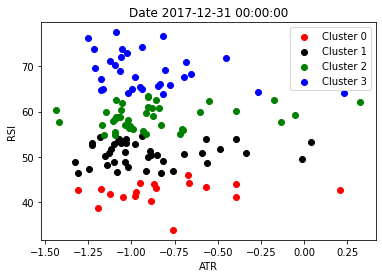

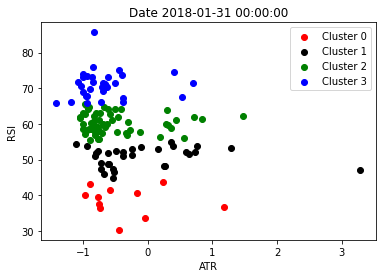

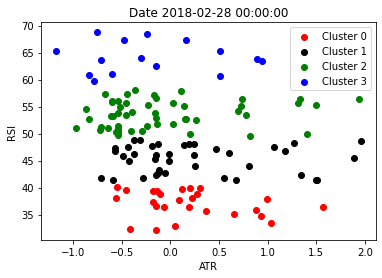

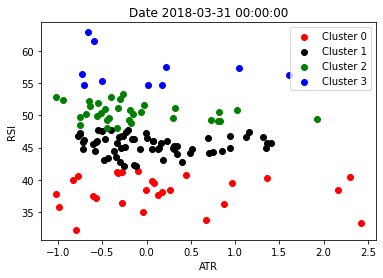

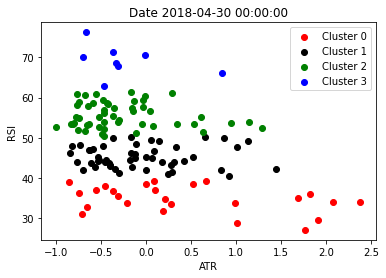

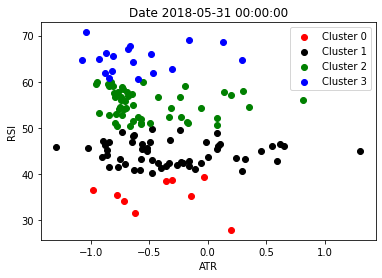

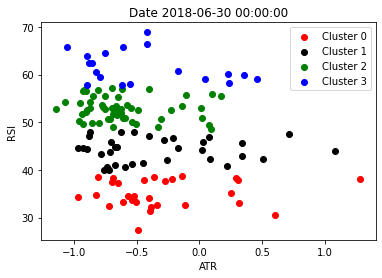

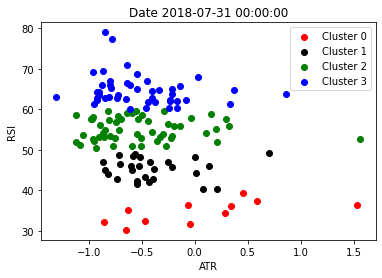

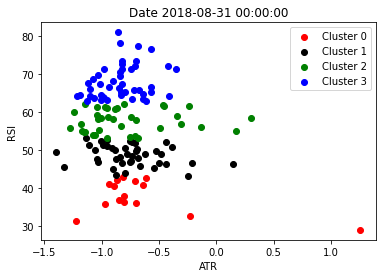

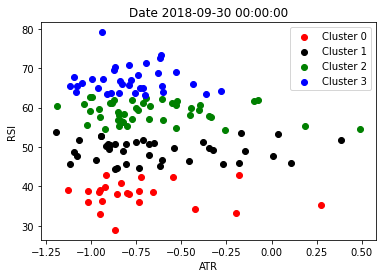

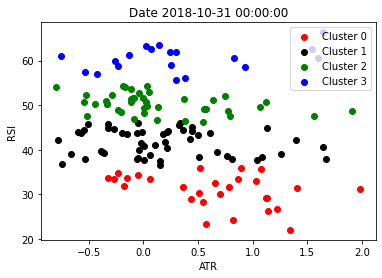

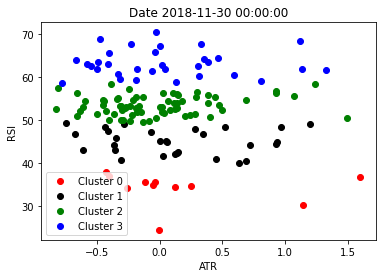

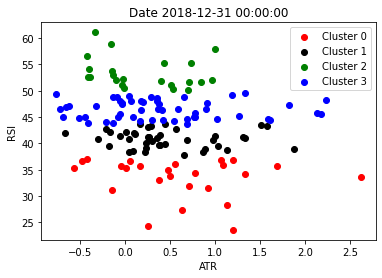

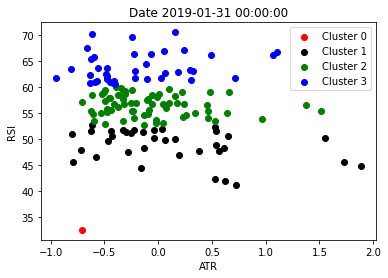

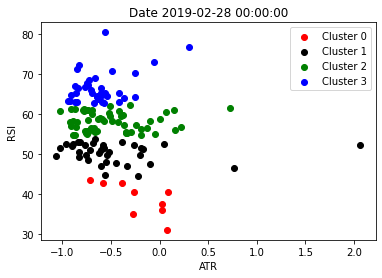

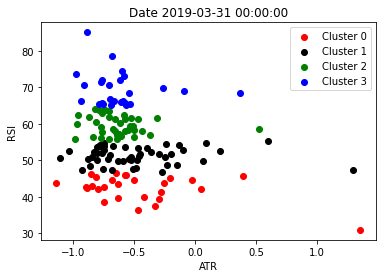

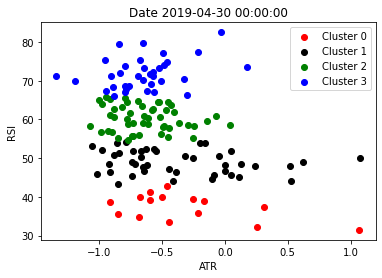

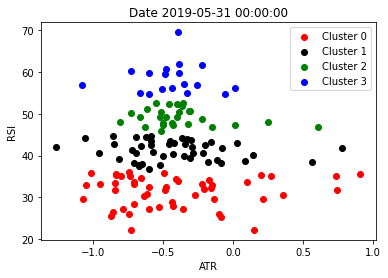

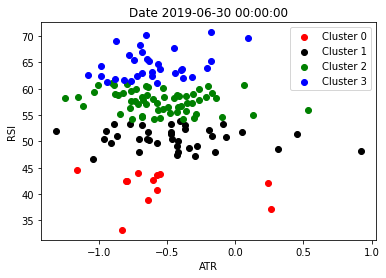

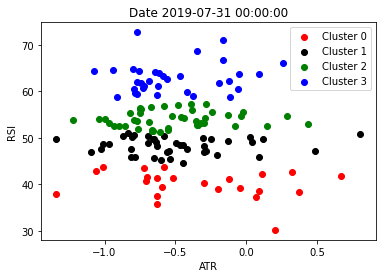

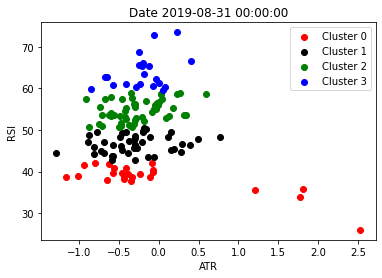

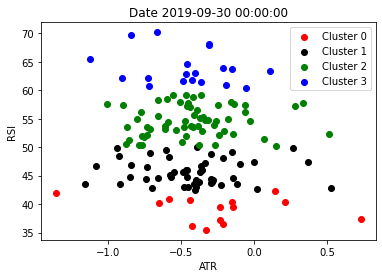

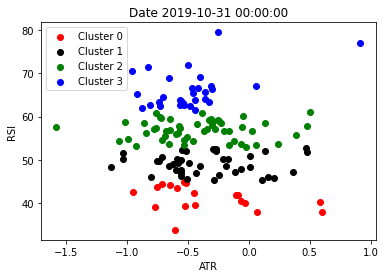

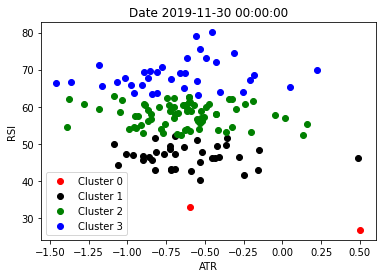

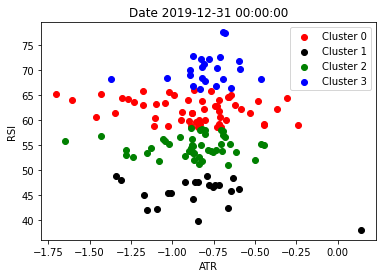

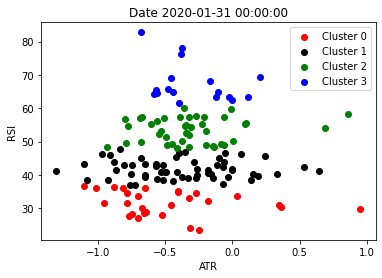

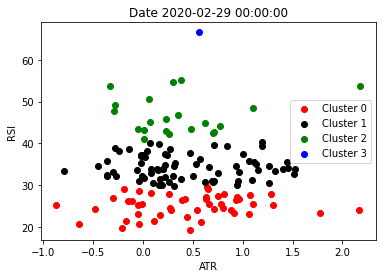

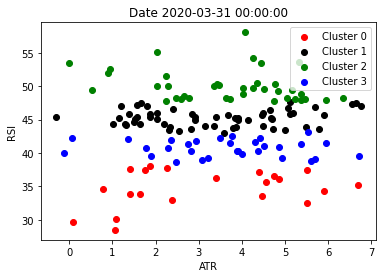

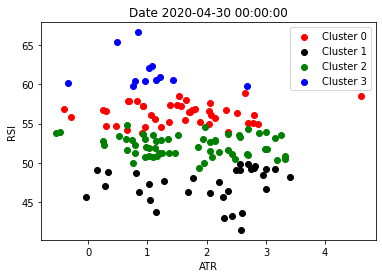

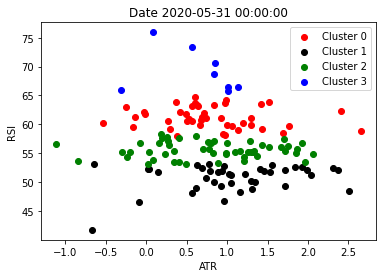

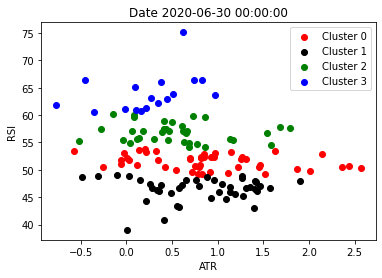

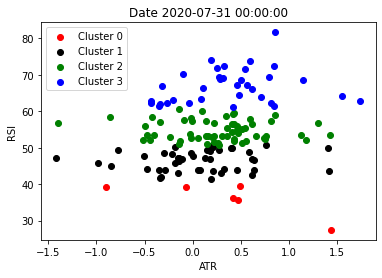

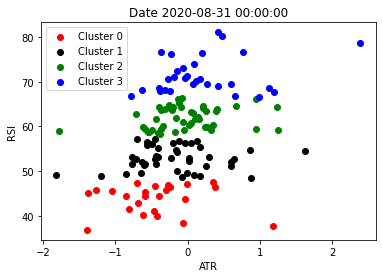

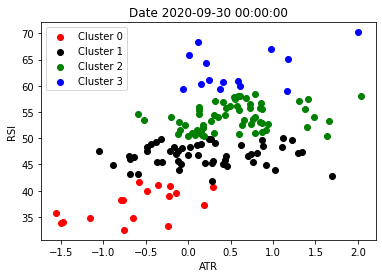

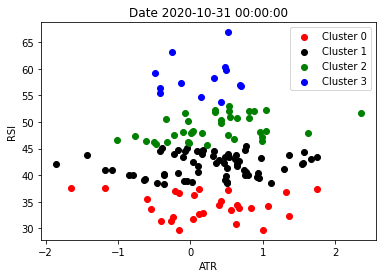

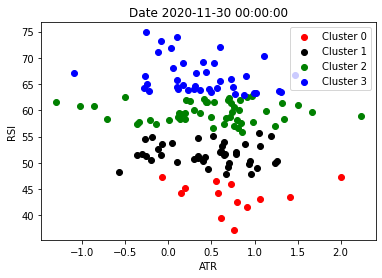

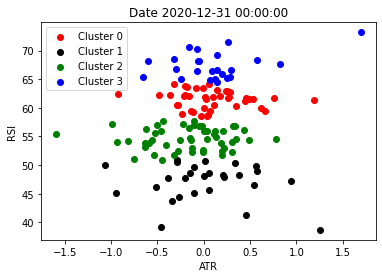

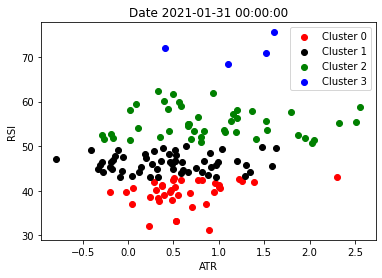

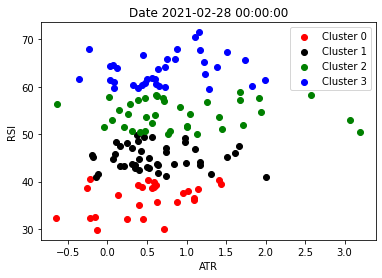

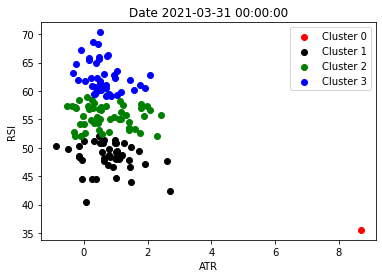

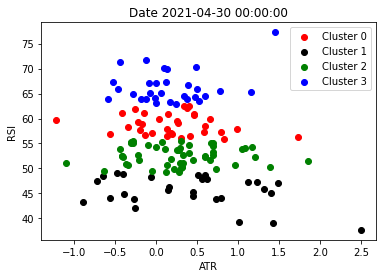

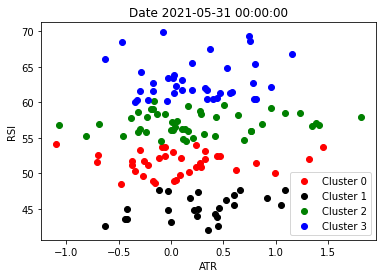

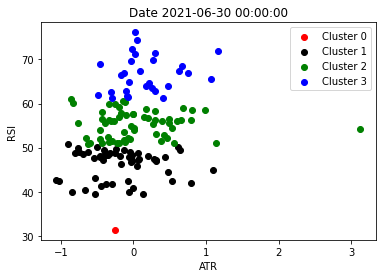

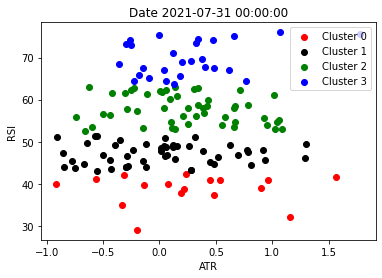

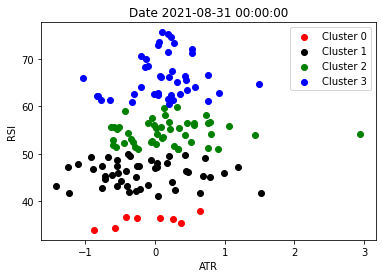

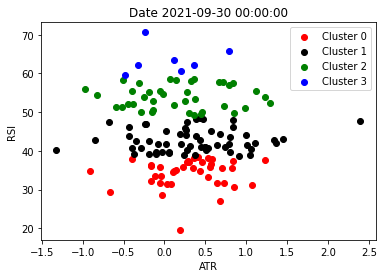

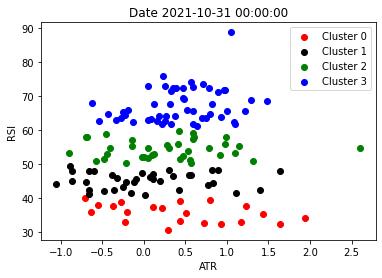

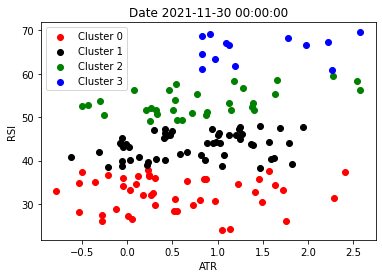

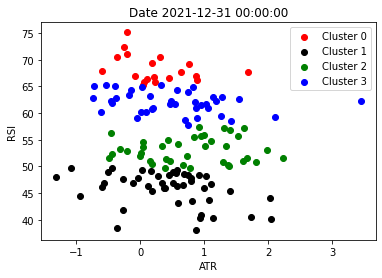

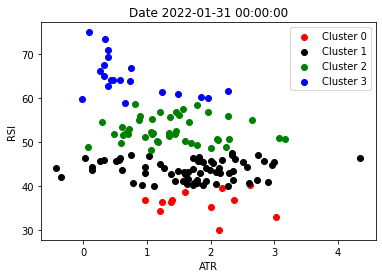

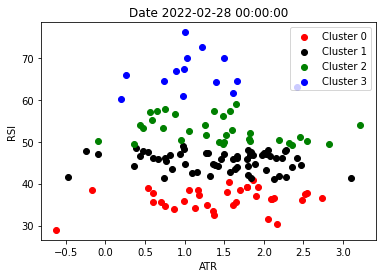

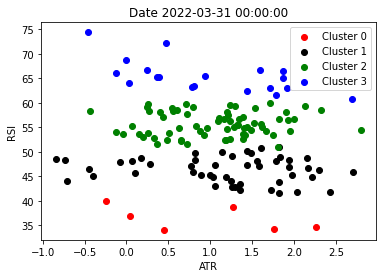

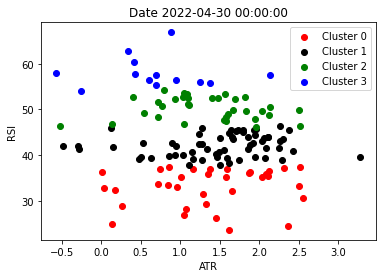

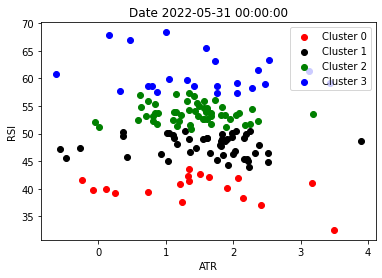

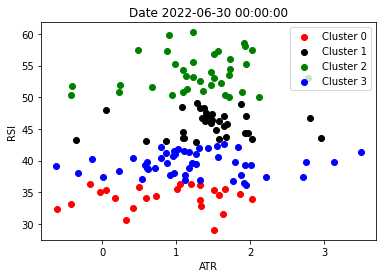

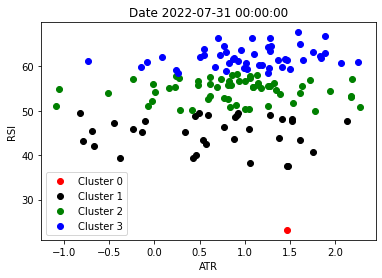

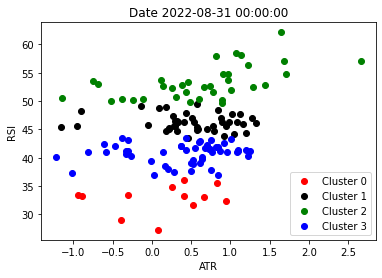

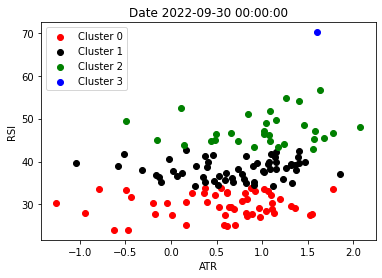

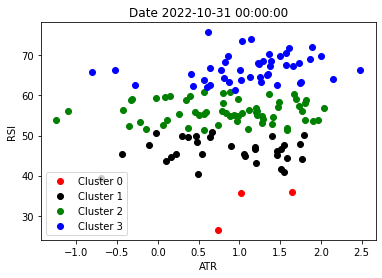

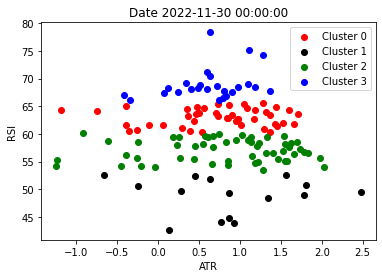

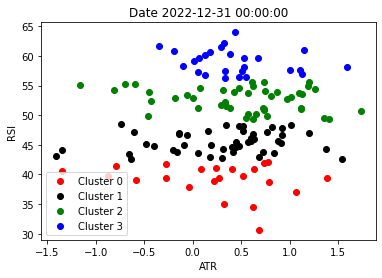

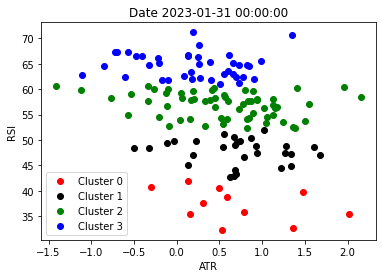

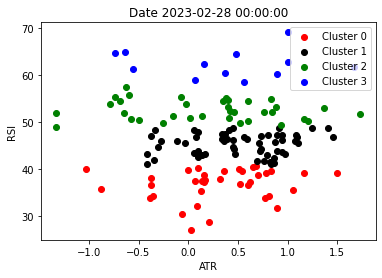

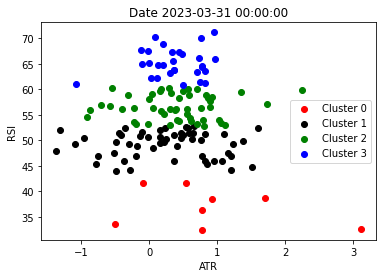

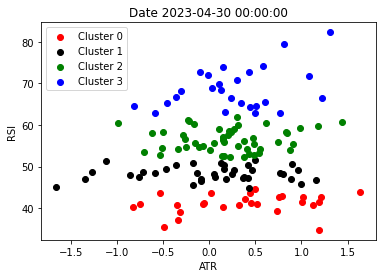

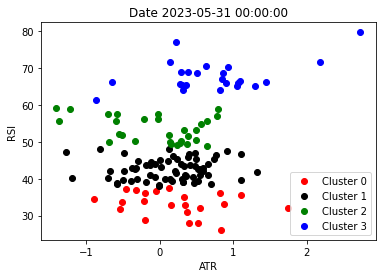

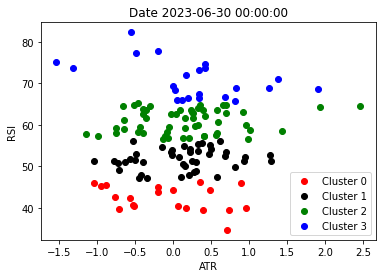

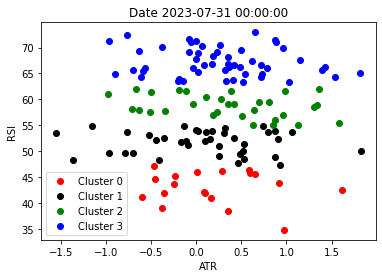

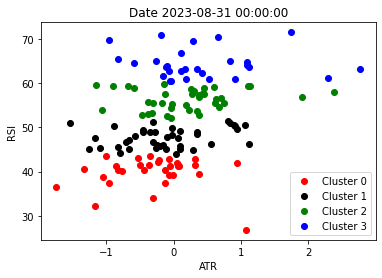

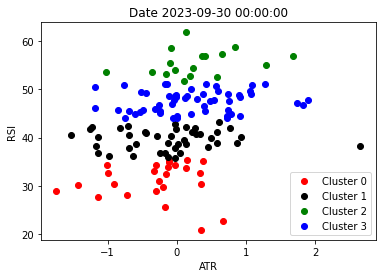

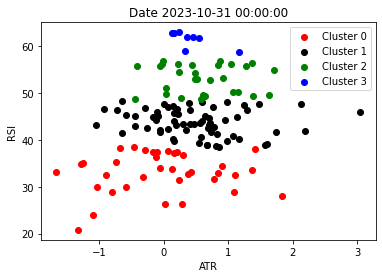

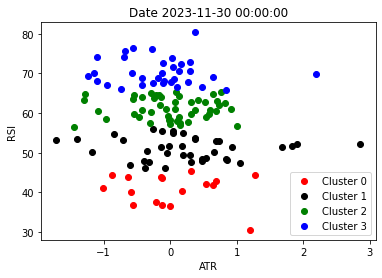

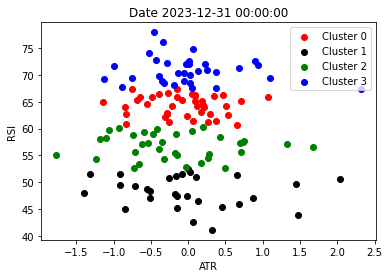

In [94]:
for i in stock_features_df.index.get_level_values('Date').unique().tolist():
    g = stock_features_df.xs(i,level=0)
    plt.title(f'Date {i}')
    plt.xlabel("ATR")
    plt.ylabel("RSI")
    plot_clusters(g)

## Select stocks based off cluster, form portfolio based on Efficient Frontier max Sharp Ratio Optimization

Hypothesis: stocks clustered around RSI 70 will outperform in following month (Cluster 3)

In [119]:
max_rsi_df = stock_features_df[stock_features_df['cluster'] == 3]
max_rsi_df = max_rsi_df.reset_index(level=1)

In [120]:
max_rsi_df.index = max_rsi_df.index + pd.DateOffset(1)
max_rsi_df = max_rsi_df.reset_index().set_index(['Date','Ticker'])
max_rsi_df

Mkt-RF       SMB       HML       RMW       CMA       ATR  \
Date       Ticker                                                               
2018-01-01 ACN     1.119493 -0.267223 -0.217404  0.225170  0.022736 -0.940480   
           BA      0.723307  1.142223 -0.144125  0.442067  0.439342 -0.804757   
           BAC     1.238249 -0.305507  1.173386 -0.627192 -0.529671 -1.016978   
           CAT     0.835748  0.350758  0.387097  0.029200  0.146218 -1.086270   
           CSCO    0.867442  0.225961 -0.202004  0.275826  0.593632 -1.165527   
...                     ...       ...       ...       ...       ...       ...   
2024-01-01 RCL     1.959279  1.407806  0.211959 -0.548331  0.109971 -0.337069   
           SHW     0.924206  0.412254 -0.047758  0.996589  0.342187  0.070429   
           TGT     1.090629  0.197525  0.153061 -0.502360  0.144261 -0.323708   
           TMUS    0.534644  0.609800 -0.086824  0.127979  0.348653  0.134402   
           UNP     0.816337  0.145718 -0.206835 -0.083677  0.401892 -0.050007   

                     BB_Low    BB_Mid  BB_Upper  GK Volatility      MACD  \
Date       Ticker                                                          
2018-01-01 ACN     4.903882  4.933999  4.964117      -0.003838  0.283566   
           BA      5.566123  5.622789  5.679454      -0.001134  0.940876   
           BAC     3.242332  3.273366  3.304400      -0.008739  0.785135   
           CAT     4.776564  4.859798  4.943032      -0.008850  1.210020   
           CSCO    3.458998  3.481640  3.504282      -0.014237  0.759665   
...                     ...       ...       ...            ...       ...   
2024-01-01 RCL     4.724033  4.812005  4.899976       0.000094  2.072255   
           SHW     5.633216  5.708066  5.782916       0.000031  2.703933   
           TGT     4.889194  4.933359  4.977524       0.000064  1.209651   
           TMUS    5.031128  5.059493  5.087858       0.000090  1.361435   
           UNP     5.426836  5.476773  5.526710       0.000026  2.063510   

                         RSI  returns_1m  returns_2m  returns_3m  returns_6m  \
Date       Ticker                                                              
2018-01-01 ACN     65.003665    0.034322    0.037001    0.045983    0.037860   
           BA      69.206701    0.065426    0.072052    0.052628    0.070896   
           BAC     64.004966    0.047923    0.040365    0.053704    0.034859   
           CAT     77.546244    0.116401    0.077211    0.083247    0.065679   
           CSCO    65.042231    0.026810    0.059020    0.047296    0.037301   
...                      ...         ...         ...         ...         ...   
2024-01-01 RCL     76.180888    0.205007    0.232213    0.120115    0.037644   
           SHW     74.792666    0.118723    0.101200    0.070191    0.027967   
           TGT     68.563405    0.064345    0.119815    0.087059    0.016057   
           TMUS    70.815994    0.065670    0.057994    0.047630    0.024945   
           UNP     70.412739    0.096454    0.089912    0.063746    0.032872   

                   returns_9m  returns_12m  cluster  
Date       Ticker                                    
2018-01-01 ACN       0.029824     0.024265        3  
           BA        0.059849     0.055138        3  
           BAC       0.026669     0.025757        3  
           CAT       0.062341     0.047756        3  
           CSCO      0.016983     0.022932        3  
...                       ...          ...      ...  
2024-01-01 RCL       0.079036     0.083562        3  
           SHW       0.037897     0.023873        3  
           TGT      -0.013835    -0.001132        3  
           TMUS      0.011843     0.011731        3  
           UNP       0.024447     0.016437        3  

[2010 rows x 19 columns]

In [122]:
dates = max_rsi_df.index.get_level_values('Date').unique().tolist()
date_dict = {}

for date in dates:
    date_dict[date.strftime('%Y-%m-%d')] = max_rsi_df.xs(date,level=0).index.tolist()
    
date_dict

{'2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  

### Define Portfolio Optimization Function

In [130]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [160]:
def optimize_weights(prices):
    returns = expected_returns.mean_historical_return(prices = prices,
                                                     frequency = 252)
    cov = risk_models.sample_cov(prices = prices, frequency = 252)
    ef = EfficientFrontier(returns, cov, weight_bounds = (0, 0.25), solver = 'SCS')
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

### Get Fresh Stock Data

In [161]:
stock_diff_df = stocks_df.dropna().unstack()['Adj Close']
stock_diff_df

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-09,33.148560,34.679176,21.709171,37.890308,NaN,31.898367,22.623333,81.816162,73.849998,41.829552,...,52.402351,31.203033,55.388115,53.010525,33.222485,41.495281,83.784012,54.680000,16.732939,37.707794
2016-02-10,33.598408,35.570351,21.544621,37.351856,NaN,32.079407,22.959999,82.596443,75.529999,41.532635,...,52.124432,30.990385,54.883209,53.698849,32.969067,41.676319,84.704811,57.799999,16.708771,37.206406
2016-02-11,33.111076,34.966652,21.414352,36.969265,NaN,31.329374,22.240000,81.912613,74.940002,41.430851,...,53.514053,30.706863,55.056118,52.564049,32.769981,40.727432,83.583435,57.639999,16.032036,37.234795
2016-02-12,33.945175,36.241131,21.480625,37.252670,NaN,32.010448,22.799999,83.026047,76.669998,42.109482,...,61.986294,30.572981,56.045200,50.908344,33.521126,42.038406,83.674599,59.310001,16.910175,38.247013
2016-02-16,34.751163,36.998158,22.086262,37.911556,NaN,32.751873,22.870001,84.963615,78.879997,44.170845,...,66.926201,30.580856,56.176609,51.810616,33.625652,43.399311,85.352127,64.389999,17.516127,38.247013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-13,129.759995,14.610000,185.039993,173.289993,150.820007,111.339996,84.059998,362.809998,601.890015,184.690002,...,103.953613,58.279999,101.339996,32.450001,121.730003,131.210007,123.160004,245.800003,38.930000,183.490005
2024-02-14,132.240005,14.860000,184.149994,174.419998,148.199997,112.059998,84.870003,370.980011,604.659973,186.320007,...,104.961227,58.680000,100.839996,32.669998,124.160004,134.009995,121.839996,252.960007,40.419998,184.080002
2024-02-15,134.750000,14.900000,183.860001,176.589996,157.690002,113.639999,87.400002,371.510010,590.440002,187.539993,...,105.480003,59.009998,103.730003,33.860001,124.419998,135.399994,124.400002,283.750000,41.520000,189.649994


In [162]:
stock_log_df = np.log(stock_diff_df).diff()

In [173]:
returns_df = pd.DataFrame()

for start_date in date_dict.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    companies = date_dict[start_date]
    optimize_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimize_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    optimize_df = stock_diff_df[optimize_start_date:optimize_end_date][companies]
    failure = True
    try:
        weights = optimize_weights(optimize_df)
        weights = pd.DataFrame(weights, index = pd.Series(0))
        failure = False
    except:
        print(f"Max Sharpe Optimization failed for {start_date}")
    if failure:
        print('hi')
        weights = pd.DataFrame([1/len(optimize_df.columns) for i in range(len(optimize_df.columns))],
                               index = optimize_df.columns.tolist(),
                               columns = pd.Series(0)).T
    log_df = stock_log_df[start_date:end_date]
    log_df = log_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').\
                                                                         reset_index(level=0,drop=True),
                                                                         left_index = True, right_index = True)\
                                                                    .reset_index().set_index(['Date','index']).unstack().stack()
    log_df.index.names = ['Date','Ticker']
    log_df['Weighted Return'] = log_df['return'] * log_df['weight']
    log_df = log_df.groupby(level=0)['Weighted Return'].sum().to_frame('Strategy Return')
    returns_df = pd.concat([returns_df, log_df])

Max Sharpe Optimization failed for 2020-03-01
hi
Max Sharpe Optimization failed for 2020-04-01
hi
Max Sharpe Optimization failed for 2022-10-01
hi


In [174]:
returns_df#.plot()

,Strategy Return
Date,
2018-01-02,-0.005010
2018-01-03,0.003757
2018-01-04,0.000460
2018-01-05,0.009670
2018-01-08,0.001132
...,...
2024-01-25,0.001607
2024-01-26,-0.014164
2024-01-29,0.018207


### Compare to SPY Benchmark

In [175]:
spy_df = yf.download('SPY', start = '2016-01-01', end = dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [181]:
spy_returns_df = np.log(spy_df[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)
spy_returns_df

,SPY Buy&Hold
Date,
2016-01-05,0.001690
2016-01-06,-0.012695
2016-01-07,-0.024284
2016-01-08,-0.011037
2016-01-11,0.000989
...,...
2024-02-12,-0.000439
2024-02-13,-0.013869
2024-02-14,0.009047


In [186]:
comp_df = returns_df.merge(spy_returns_df,left_index = True, right_index=True)

(array([17532., 17713., 17897., 18078., 18262., 18444., 18628., 18809.,
        18993.]),
 [Text(17532.0, 0, '2018-01'),
  Text(17713.0, 0, '2018-07'),
  Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01')])

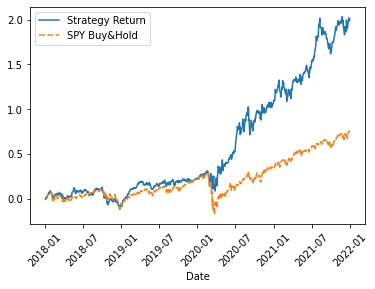

In [194]:
cum_returns_df = np.exp(np.log1p(comp_df).cumsum()) - 1

sns.lineplot(cum_returns_df[:'2022-01-01'])
plt.xticks(rotation=45)